In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import time
import shutil

In [3]:
MNM_nb_folder = os.path.join('..', '..', '..', 'side_project', 'network_builder')
sys.path.append(MNM_nb_folder)

In [5]:
import MNM_nb
import macposts

In [6]:
data_folder = os.path.join('..', '..', '..', 'data', 'input_files_2link_fix')
new_folder = os.path.join('MNM_cache', 'input_files_2link_fix')

In [11]:
nb = MNM_nb.MNM_network_builder()

MNM_config
MNM_pathtable


In [12]:
nb.load_from_folder(data_folder)

No config file
No link input
No node input
No graph input
No OD input
No demand input
No path table input


In [13]:
nb.config

KeyError: 'DTA'

## Config

In [9]:
observed_links = [3]
estimated_paths = np.arange(0, 2)

### dar

In [10]:
from scipy.sparse import coo_matrix
def massage_raw_dar(raw_dar, f, num_link, ass_freq, observed_links, estimated_paths, num_interval):
    num_e_path = len(estimated_paths)
    num_e_link = len(observed_links)
    link_seq = (np.array(map(lambda x: observed_links.index(x), raw_dar[:, 2].astype(np.int)))
                + raw_dar[:, 3] * num_e_link / ass_freq).astype((np.int))
    path_seq = (raw_dar[:, 0] + raw_dar[:, 1] * num_e_path).astype(np.int)
    p = raw_dar[:, 4] / f[path_seq]

    mat = coo_matrix((p, (link_seq, path_seq)), 
                   shape=(num_interval * num_e_link, num_interval * num_e_path)).toarray()
    return mat

In [11]:
def get_x(f, nb, observed_link_list, estimated_paths, new_folder):
    num_interval = nb.config.config_dict['DTA']['max_interval']
    ass_freq = nb.config.config_dict['DTA']['assign_frq']
    num_link = nb.config.config_dict['DTA']['num_of_link']
    total_interval = num_interval * ass_freq
    nb.config.config_dict['DTA']['total_interval'] = total_interval * 2
    num_path = nb.config.config_dict['FIXED']['num_path']
    nb.update_demand_path(f)
    nb.dump_to_folder(new_folder)
    a = MNMAPI.dta_api()
    a.initialize(new_folder)
    a.register_links(observed_link_list)
    a.register_paths(estimated_paths)
    a.install_cc()
    a.install_cc_tree()
    a.run_whole()
    x = a.get_link_inflow(np.arange(0, total_interval, ass_freq), np.arange(0, total_interval, ass_freq) + ass_freq).reshape((len(observed_link_list), total_interval/ass_freq), order = 'F').flatten()
    raw_dar = a.get_dar_matrix(np.arange(0, total_interval, ass_freq), np.arange(0, total_interval, ass_freq) + ass_freq)
    dar = massage_raw_dar(raw_dar, f, num_link, ass_freq, observed_link_list, estimated_paths, num_interval)
    return x, dar

### actual OD

In [12]:
total_interval = 100
ass_freq = 10
num_path = nb.config.config_dict['FIXED']['num_path']
num_link = nb.config.config_dict['DTA']['num_of_link']
num_interval = nb.config.config_dict['DTA']['max_interval']

In [13]:
f_real = np.random.rand(num_path * num_interval) * 10
x_real, dar = get_x(f_real, nb, observed_links, estimated_paths, new_folder)

In [14]:
x_real

array([ 10.2,   9.4,  12.3,  10.6,   6. ,   8.4,   9.5,   5.6,  18.7,  15.1])

In [15]:
# nb.update_demand_path(f_real)

In [16]:
# nb.dump_to_folder(new_folder)

In [35]:
hash = hashlib.sha1()
hash.update(str(time.time()))
new_folder = str(hash.hexdigest())
nb.update_demand_path(f_real)
nb.dump_to_folder(new_folder)
a = MNMAPI.dta_api()
a.initialize(new_folder)
shutil.rmtree(new_folder)
a.register_links([3])
a.register_paths(np.arange(0, 2))
a.install_cc()
a.install_cc_tree()
a.run_whole()

0L

3a8dc14d8397ac668c13e28c2303949e494ee015
3a8dc14d83


In [18]:
a.get_dar_matrix(np.arange(0, total_interval, ass_freq), np.arange(0, total_interval, ass_freq) + ass_freq)

array([[  1. ,   0. ,   3. ,   0. ,   2. ],
       [  0. ,   0. ,   3. ,   0. ,   8.2],
       [  1. ,   1. ,   3. ,  10. ,   7.7],
       [  0. ,   1. ,   3. ,  10. ,   1.7],
       [  1. ,   2. ,   3. ,  20. ,   7.9],
       [  0. ,   2. ,   3. ,  20. ,   4.4],
       [  1. ,   3. ,   3. ,  30. ,   7.5],
       [  0. ,   3. ,   3. ,  30. ,   3.1],
       [  1. ,   4. ,   3. ,  40. ,   1.5],
       [  0. ,   4. ,   3. ,  40. ,   4.3],
       [  1. ,   5. ,   3. ,  50. ,   2.2],
       [  0. ,   5. ,   3. ,  50. ,   6.2],
       [  1. ,   6. ,   3. ,  60. ,   5.2],
       [  0. ,   6. ,   3. ,  60. ,   4.3],
       [  1. ,   7. ,   3. ,  70. ,   5.1],
       [  0. ,   7. ,   3. ,  70. ,   0.5],
       [  1. ,   8. ,   3. ,  80. ,   9.3],
       [  0. ,   8. ,   3. ,  80. ,   9.4],
       [  1. ,   9. ,   3. ,  90. ,   8.7],
       [  0. ,   9. ,   3. ,  90. ,   6.5]])

In [19]:
# a.get_cur_loading_interval()

## Estimate

In [20]:
f_e = np.random.rand(num_path * num_interval)*5
x_e, dar_e = get_x(f_e, nb, observed_links, estimated_paths, new_folder)

In [21]:
step_size = 0.1

In [22]:
for i in range(50):
    x_e, dar = get_x(f_e, nb, observed_links, estimated_paths, new_folder)
    grad = - dar.T.dot(x_real - x_e)
    print np.linalg.norm(x_e - x_real), np.linalg.norm(f_e - f_real)
    f_e -= grad * step_size / np.sqrt(i + 1)

23.5376294473 19.8221021911
18.8098378515 17.1012877641
16.1576607218 15.7290242259
14.302447343 14.8251908409
12.8965111561 14.1780141447
11.8156675647 13.6889887948
10.8013887996 13.3078558297
9.90656348084 13.0030588674
9.22117129219 12.7573857219
8.6197447758 12.5538310467
8.13265024454 12.3845649729
7.56967634711 12.2405250131
7.18401002226 12.1197252491
6.81322243876 12.0154093914
6.46219776856 11.9258241172
6.10573500899 11.8481695295
5.92030404625 11.7809503382
5.54256258422 11.7209728028
5.26497863244 11.5408047449
5.08527285404 11.4883752648
4.77912125814 11.4399022098
4.6357307946 11.3973191703
4.38178046004 11.3589897755
4.20119030752 11.3248535897
4.05215991787 11.2941844646
3.92428337407 11.2665277787
3.68374809128 11.2414682735
3.63455636908 11.2190599532
3.45832329316 11.1976736378
3.27261363439 11.1785190687
3.26190128606 11.1612369897
3.17490157328 11.1450025941
2.99666481275 11.1301888161
2.80356915378 11.1167586735
2.64575131106 11.1048970135
2.683281573 11.09418719

In [23]:
f_e

array([ 4.27074717,  5.77188792,  5.27645651,  3.71264918,  6.82524988,
        4.81834652,  5.01495382,  5.45732112,  0.59254426,  5.18963998,
        5.06661818,  2.99915968,  4.4734873 ,  4.6135044 ,  2.20526426,
        3.58759296,  7.93295609,  9.64893005,  5.15826192,  9.21908952])

In [24]:
f_real

array([ 8.15804598,  1.95560978,  1.65903667,  7.65930837,  4.34551743,
        7.94650391,  3.09611815,  7.46724298,  4.31241003,  1.52434044,
        6.17122785,  2.2181613 ,  4.25540151,  5.14555835,  0.44283175,
        5.11350549,  9.37581069,  9.36942636,  6.44685073,  8.72100766])

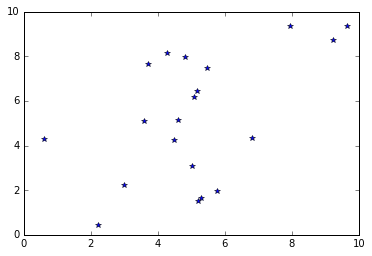

In [26]:
plt.plot(f_e, f_real, '*')
plt.show()